In [1]:
#import sys
#sys.path.insert(0, '/Users/timkrausz/Documents/GitHub/Maze-photometry-analyses/')

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.io
import statsmodels.api as sm
from sklearn.linear_model import Lasso
#from phot_funcs import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from TriFuncs import airPLS, WhittakerSmooth, get_zdFF
#from hex_making_utils import *
#import fit_hex_grid
#%matplotlib qt

In [2]:

def transform_scatter(points, image, rotate_center=(0,0)):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.subplots_adjust(left=0.25, bottom=0.25)

    ax.imshow(image, extent=[0, 640, 0, 480])
    scatter = ax.scatter(points[:,0], points[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

    axcolor = 'lightgoldenrodyellow'
    ax_scale = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    ax_translate_x = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)
    ax_translate_y = plt.axes([0.25, 0.0, 0.65, 0.03], facecolor=axcolor)
    ax_rotate = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

    s_scale = Slider(ax_scale, 'Scale', 0.1, 1.5, valinit=1.0)
    s_translate_x = Slider(ax_translate_x, 'Translate X', -200, 200, valinit=0)
    s_translate_y = Slider(ax_translate_y, 'Translate Y', -200, 200, valinit=0)
    s_rotate = Slider(ax_rotate, 'Rotate', -30, 30, valinit=0)

    def update(val):
        #clear_output()
        scale = s_scale.val
        translate_x = s_translate_x.val
        translate_y = s_translate_y.val
        rotate_deg = s_rotate.val

        # Scale
        scale_matrix = np.array([[scale, 0, 0],
                                 [0, scale, 0],
                                 [0, 0, 1]])

        # Translate
        translate_matrix = np.array([[1, 0, translate_x],
                                     [0, 1, translate_y],
                                     [0, 0, 1]])

        # Rotate
        rotate_rad = np.deg2rad(rotate_deg)
        rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                                  [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                                  [0, 0, 1]])

        # Rotate around specified center
        center_matrix = np.array([[1, 0, rotate_center[0]],
                                  [0, 1, rotate_center[1]],
                                  [0, 0, 1]])
        center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                            [0, 1, -rotate_center[1]],
                                            [0, 0, 1]])
        rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

        # Transform points
        transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
        transformed_points = transform_matrix.dot(points.T).T

        # Update scatter plot
        scatter.set_offsets(transformed_points[:,:2])
        #scatter.set_color(transformed_points[:,2])

        fig.canvas.draw_idle()
        global new_coords
        new_coords = transformed_points[:,:2]
        global transformParams
        print("rotate degree, scale, x tran, y tran = ",[rotate_deg,scale,translate_x,translate_y])
        transformParams = [rotate_deg,scale,translate_x,translate_y]
        #print(transformed_points)
    s_scale.on_changed(update)
    s_translate_x.on_changed(update)
    s_translate_y.on_changed(update)
    s_rotate.on_changed(update)

    plt.show()
    
def assign_to_hexagon(x, y, centroids):
    """
    Assigns each point in the given x-y coordinate vector to the closest hexagonal region of interest
    with the specified centroids.
    Parameters:
        x (np.ndarray): A 1D numpy array of x-coordinates.
        y (np.ndarray): A 1D numpy array of y-coordinates.
        centroids (np.ndarray): A 2D numpy array of hexagonal region centroids, where each row contains
            the x and y coordinates of the centroid of a region of interest.
    Returns:
        A 1D numpy array of integers, where each element is the index of the closest centroid in the
        centroids array.
    """
    # Calculate the Euclidean distance between each point and each centroid
    distances = np.sqrt((x[:, np.newaxis] - centroids[:, 0])**2 + (y[:, np.newaxis] - centroids[:, 1])**2)
    # Find the index of the closest centroid for each point
    closest_centroid_indices = np.argmin(distances, axis=1) +1
    
    return closest_centroid_indices

#compute the centroids of the initial hexagons
hexlist = [2,47,46,45,44,43,3,\
49,42,41,40,39,48,\
38,37,36,35,34,33,\
32,31,30,29,28,\
27,26,25,24,23,\
22,21,20,19,\
18,17,16,15,\
14,13,12,\
11,10,9,\
8,7,\
6,5,\
4,\
1]
#hexlist = np.subtract(hexlist,1) #convert to index-based states
coords = []
cols = [7,6,6,5,5,4,4,3,3,2,2,1,1]
maxrows = 13
r = 0
x = 1
y = 1
startr = 1
while r < maxrows:
    maxcols = cols[r]
    c = 0
    if r%2!=0:
        startr+=1
    x=startr
    while c < maxcols:
        coords.append([x,y])
        x += 2
        c += 1
    if r%2!=0:
        y += 2
    else:
        y+=1
    r += 1
cents = {h: c for h,c in zip(hexlist,coords)}


# define the centroids of the hexagons
centroids = np.zeros((49,2))
for h in list(cents.keys()):
    centroids[h-1] = cents[h]

centroids[:,0] = centroids[:,0]/centroids[:,0].max()*450 +80
centroids[:,1] = centroids[:,1]/centroids[:,1].max()*410



In [38]:
sampledata.loc[sampledata.x.notnull()].index

Int64Index([    456,     476,     492,     511,     531,     544,     562,
                582,     597,     612,
            ...
            1803631, 1803653, 1803667, 1803683, 1803704, 1803719, 1803735,
            1803753, 1803771, 1803787],
           dtype='int64', length=100566)

In [41]:
len(position)

104678

In [56]:
sampledata.loc[:,'x']=np.nan
sampledata.loc[:,'y']=np.nan
sampledata.loc[framestamps,'x']=position[:,0]
sampledata.loc[framestamps,'y']=position[:,1]

In [30]:
position = smooth_position_data(np.transpose([x,y]),window_size=3)

In [70]:
position = remove_aberrant_jumps(position_data=np.transpose([x,y]),\
    max_jump_distance=30*3.14)
position = smooth_position_data(position,window_size=5)

In [80]:
plt.figure()
plt.plot(x[~np.isnan(x)],y[~np.isnan(x)])
plt.plot(position[~np.isnan(position[:,0]),0],position[~np.isnan(position[:,0]),1])

In [28]:
x,y,vel,framestamps,acc,dlc_pos = align_pos_to_visits(phot_to_dframes.Fs,phot_to_dframes.vis4pos,phot_to_dframes.datepath,
    phot_dlc=phot_to_dframes.phot_dlc,filecount=phot_to_dframes.filecount,gaus_smooth=phot_to_dframes.usePosSmoothing,sigma=phot_to_dframes.gausSigma)

rat:  1594
date:  07282023
Block change = prob or barrier?  barrier
photometry DLC? y/n n


[  137379   385761   874719  1052774  1299611  1589850  2776896  2980950
  3333307  3627428  3949859  4204490  4706959  5015079  5334900  5634651
  5729882  5937583  6171714  6285487  6406004  6514001  6594683  6876247
  6968872  7278300  7515778  7686916  7796854  8393962  8658046  8757357
  8910400  9565838 10466892 10591904 10890419 11227054 11473634 11603202
 11745176 12584313 12974136 13114661 13307289 13472818 14019163 14159336
 14358761 14488215 14993715 15928659 16497353 16705029 17065183 17358602
 17776545 17973831 18416614 19242571 19867414 20173693 20625856 20807235
 20914184 21163867 21488655 21722418 21940627 22080687 22295985 22436171
 23024992 23138698 23467332 23593118 24048266 25284232 25563402 26265666
 26947835 29298344 29720332 29926827 30271209 30617872 30830364 31388082
 31560972 31941254 33310789 34221358 35409891 35668060 35927969 36654649
 38022250 38578160 38933651 39211168 40408771 41305355 41654566 41858181
 41998913 43775776 44072578 45088400 45185102 45609

adjust visits by removing n indices from start? (input n; if 1 is first index, input 1) 0


end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached


min length of A-C in block 1.0? 15
min length of B-C in block 1.0? 17
min length of A-B in block 1.0? 17
min length of A-C in block 2.0? 21
min length of B-C in block 2.0? 17
min length of A-B in block 2.0? 15
min length of A-C in block 3.0? 15
min length of B-C in block 3.0? 17
min length of A-B in block 3.0? 17


Memory usage of dataframe is 495.81 MB
Memory usage after optimization is: 127.40 MB
Decreased by 74.3%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
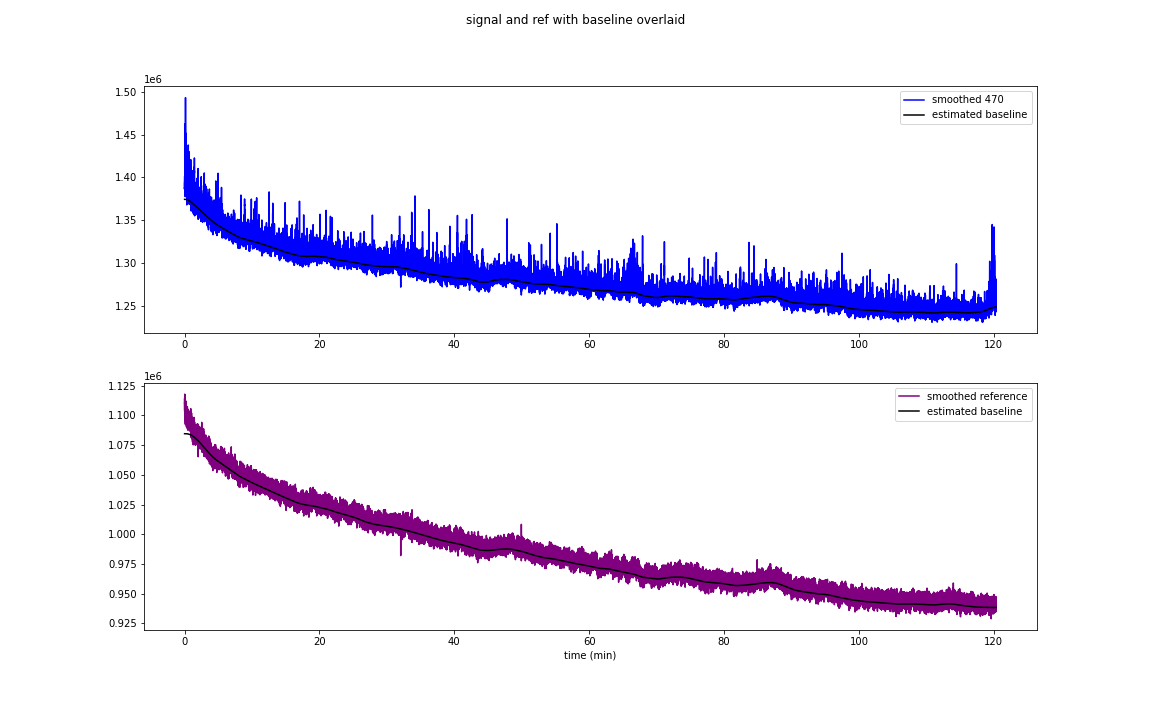

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
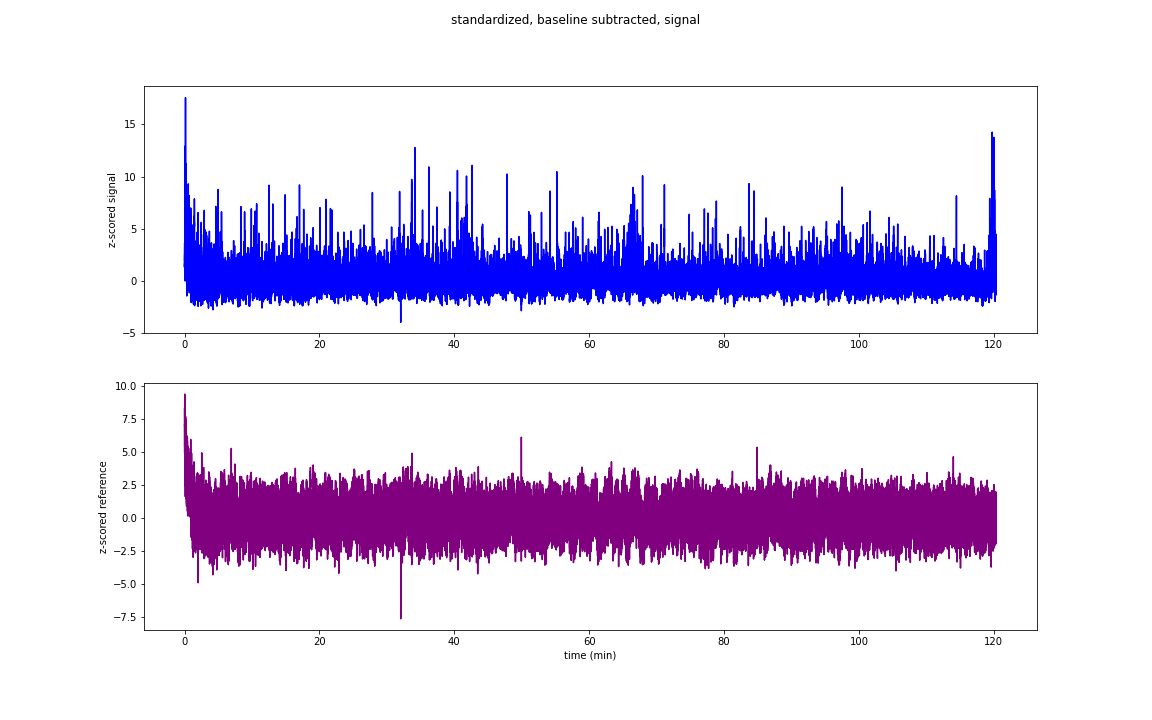

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
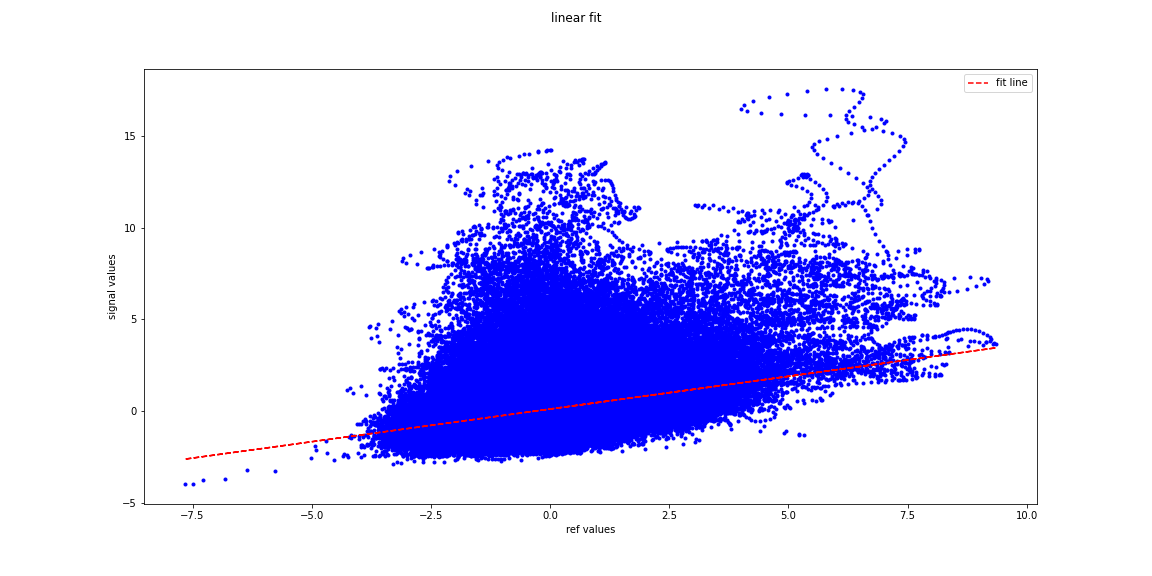

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
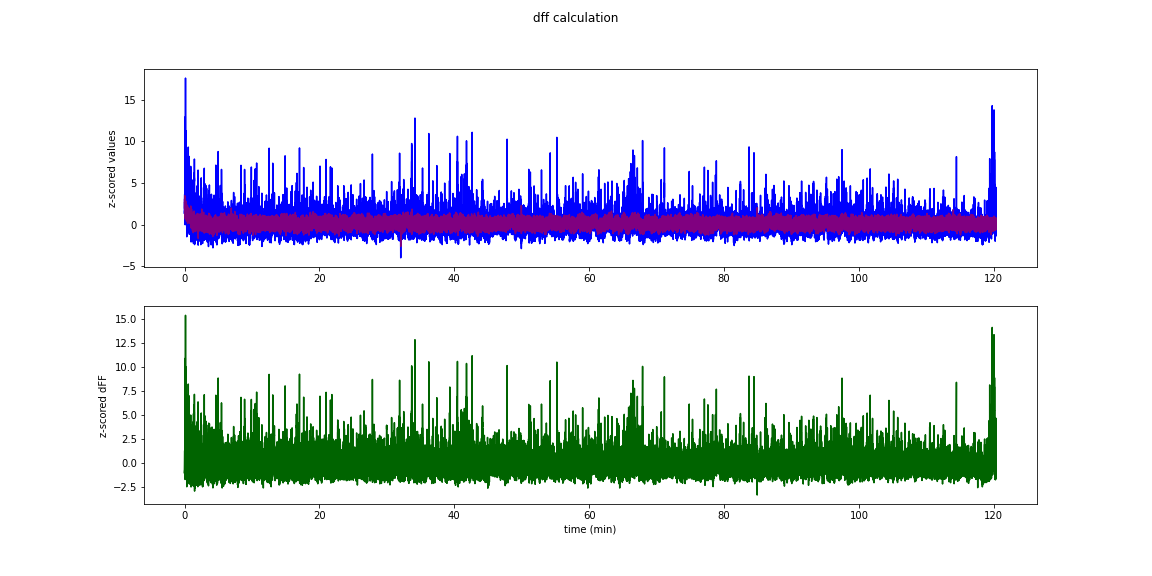

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
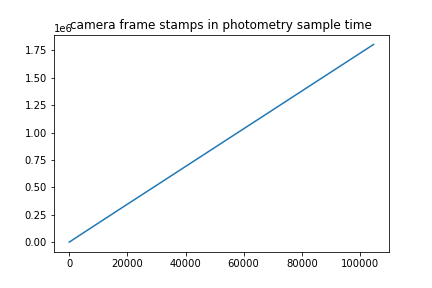

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
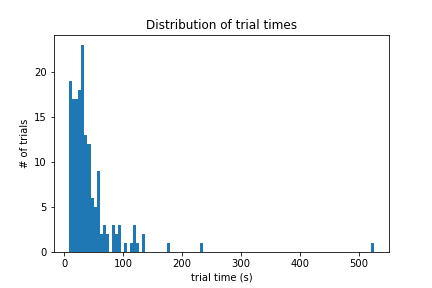

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
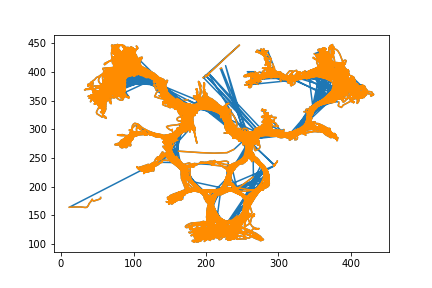

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
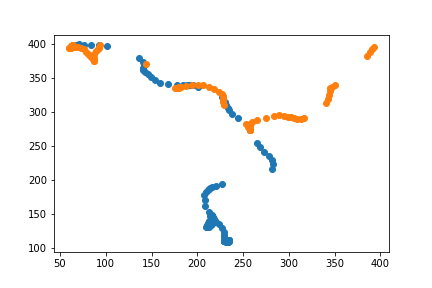

In [3]:
%matplotlib qt
animal = "IM-"+input('rat: ') #i.e. IM-1006
#filepath = "/Volumes/Tim-1/Photometry Data/"+ animal + '/'
filepath = "/Volumes/Tim/Photometry/"+ animal + '/'
#filepath = "/Volumes/Tim K/Photometry Data/Triangle Maze/"+ animal + '/'
date = input('date: ') #format: mmddyyyy
ses_type = input('Block change = prob or barrier? ')
analcolor = 'green'# input('color of dLight?')
filecount = '0'# input('file suffix number: ')
# std used for gaussian smoothing of position data. In Weill building,
# recommend using sigma = 2
gausSigma = 0.1
usePosSmoothing = False

import phot_to_dframes

location = phot_to_dframes.location
sampledata = phot_to_dframes.sampledata
tridat = phot_to_dframes.tridat
visinds = sampledata.loc[sampledata.port.notnull(),:].index
fs = phot_to_dframes.Fs
datepath = savepath = phot_to_dframes.datepath

#sampledata.loc[:,'x'] = sampledata.loc[:,'x'].interpolate()
#sampledata.loc[:,'y'] = sampledata.loc[:,'y'].interpolate()

In [49]:
sampledata.loc[(sampledata.x>190)&(sampledata.x<250)&(sampledata.y>387)&(sampledata.y<450),'x']=np.nan
sampledata.loc[(sampledata.x>190)&(sampledata.x<250)&(sampledata.y>387)&(sampledata.y<450),'y']=np.nan

In [52]:
sampledata.loc[(sampledata.x>240)&(sampledata.x<265)&(sampledata.y>317)&(sampledata.y<335.3),'x']=np.nan
sampledata.loc[(sampledata.x>240)&(sampledata.x<265)&(sampledata.y>317)&(sampledata.y<335.3),'y']=np.nan

In [6]:
%matplotlib qt

In [79]:
plt.figure()
plt.plot(sampledata.loc[sampledata.x.notnull(),'x'],\
         sampledata.loc[sampledata.x.notnull(),'y'])
plt.scatter(sampledata.x,sampledata.y,color='darkorange')

In [78]:
plt.figure()
i=30
plt.scatter(sampledata.loc[visinds[i+0]:visinds[i+1],'x'],sampledata.loc[visinds[i+0]:visinds[i+1],'y'])
plt.scatter(sampledata.loc[visinds[i+1]:visinds[i+2],'x'],sampledata.loc[visinds[i+1]:visinds[i+2],'y'])


# if the video has been labeled using a cropped area, make sure to adjust position to account for the offset. x += 85

In [4]:
sampledata.loc[:,"x"] = sampledata.loc[:,"x"].values+85

# flip y position values to fit with hex map

In [5]:
y_pos = sampledata.y.values
y_midpoint = 480/2
flipped_y_values = y_midpoint + (y_midpoint - y_pos)
sampledata.loc[:,"y"] = flipped_y_values

# adjust hex map to fit the video

In [6]:
path = "/Volumes/Tim K/Photometry Data/Triangle Maze/"
#path = '/Users/berkelab/Desktop/Photometry Data/Triangle Maze/'
#path = '/Volumes/Seagate Backup Plus Drive/Data Backups/Photometry Data/Triangle Maze/'
#original_hexbins = np.load(path+'original_hexbins.npy',allow_pickle = True)
original_hexbins = np.load(path+'newMaze_hexbins.npy',allow_pickle = True)
#original_ids = np.load(path+'original_ids.npy',allow_pickle = True)
original_ids = np.load(path+'newMaze_ids.npy',allow_pickle = True)
#original_points = np.load(path+'original_points.npy',allow_pickle = True)
original_points = np.load(path+'new_points.npy',allow_pickle = True)

#run this to draw line. Can redraw as many times as needed
#draw circles in barriers, save to barriers. draw hexes 1,2,3,25 and save to new_points
import imageio
fname = datepath+'Behav_Vid'+filecount+'.avi'
vid = imageio.get_reader(fname, 'ffmpeg')

from fit_hex_grid import *
hexmap = HexMap(None,None,
                None,ses_type)

### transform_scatter will transform the scatter plot of hexes to fit the new map. the coordinates for each transformed centroid will be stored in the "new_coords" variable (in order of hex ID). You can access the transform parameters in the global variable "transformParams"

In [7]:
%matplotlib qt

In [44]:
transform_scatter(np.hstack([centroids,np.ones((len(centroids),1))]),vid.get_data(1000),rotate_center=[640/2,480/2])

In [8]:
transformParams

[-0.5384615384615401, 0.7676923076923075, 83.07692307692304, 89.74358974358967]

### save the transform parameters for quick future access

In [9]:
np.save(datepath+"transformparams.npy",transformParams)

### load transform parameters if fit has already been established and saved

In [8]:
[rotate_deg,scale,translate_x,translate_y] = np.load(f"{filepath}/07252023/transformparams.npy")

In [9]:
points = np.hstack([centroids,np.ones((len(centroids),1))])

rotate_center=[640/2,480/2]
# Scale
scale_matrix = np.array([[scale, 0, 0],
                         [0, scale, 0],
                         [0, 0, 1]])

# Translate
translate_matrix = np.array([[1, 0, translate_x],
                             [0, 1, translate_y],
                             [0, 0, 1]])

# Rotate
rotate_rad = np.deg2rad(rotate_deg)
rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                          [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                          [0, 0, 1]])

# Rotate around specified center
center_matrix = np.array([[1, 0, rotate_center[0]],
                          [0, 1, rotate_center[1]],
                          [0, 0, 1]])
center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                    [0, 1, -rotate_center[1]],
                                    [0, 0, 1]])
rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

# Transform points
transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
transformed_points = transform_matrix.dot(points.T).T

new_coords = transformed_points[:,:2]

# identify barriers
## *be sure to click on the base of the barrier (where the overlaid hex is), not the top.*

In [10]:
all_bars = []
bind = 0

In [11]:
blocks = sampledata.block.unique()

In [12]:
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("x = %d, y = %d" % (ix, iy))
    bar_coords.append((ix, iy))
print('max ind = ',len(blocks)-1)
b = blocks[bind]
ind = int(sampledata.loc[sampledata.block==b].index[int(phot_to_dframes.Fs*300)]/250*15) #5min into block
fig,ax = plt.subplots(figsize=(14,10))
ax.imshow(vid.get_data(ind), extent=[0, 640, 0, 480])
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
#for h in range(len(hexmap.ids)):
#    plt.text(hexmap.new_hexes[h].centroid.x-10,hexmap.new_hexes[h].centroid.y+10,hexmap.ids[h],\
#            color='whitesmoke',fontweight='demibold')
bar_coords = []
# connect the click event handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# show the plot
plt.show()

max ind =  2


In [13]:
all_bars.append(assign_to_hexagon(np.array(bar_coords)[:,0],np.array(bar_coords)[:,1],new_coords))
bind += 1

# convert position to hex ID

In [14]:
hexes = assign_to_hexagon(sampledata.loc[sampledata.x.notnull(),'x'],sampledata.loc[sampledata.x.notnull(),'y'],new_coords)

<ipython-input-2-c3d0fabc7fb2>:87: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  distances = np.sqrt((x[:, np.newaxis] - centroids[:, 0])**2 + (y[:, np.newaxis] - centroids[:, 1])**2)


# *Todo: hexmap is not aligning (in space) with position data!!!!!! Hex classification is not ok!!*
- y axis needs to be flipped. Done
- x axis has an offset... THIS IS BECAUSE DLC IS USING CROPPED AREA, NEED TO RUN CELL ABOVE THAT ADDS 85 TO X

## sanity check that position is getting binned in the correct hexes

In [15]:
plt.figure()
plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values,sampledata.loc[sampledata.x.notnull(),'y'].values)
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

In [16]:
def plot_pos_and_its_hex(i):
    plt.clf()
    plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values[i],sampledata.loc[sampledata.x.notnull(),'y'].values[i])
    plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
    plt.scatter(new_coords[hexes[i]-1,0],new_coords[hexes[i]-1,1],marker='H',color='darkred',alpha=0.5,s=1000)

In [17]:
plt.figure()
interact(plot_pos_and_its_hex,i = widgets.IntSlider(
    value=20000,
    min=1,
    max=len(sampledata.loc[sampledata.x.notnull(),'x']),
    step=1,
    description='frame #:'))

interactive(children=(IntSlider(value=20000, description='frame #:', max=1797211, min=1), Output()), _dom_clas…

<function __main__.plot_pos_and_its_hex(i)>

In [ ]:
#seshdat = Photrat(animal,date)
#seshdat.df = sampledata

In [18]:
#seshdat.barIDs = np.array(barrier_ids)
#if barrier session, do for each block
#seshdat.tmats = {b:[] for b in np.arange(len(blocks))}
if ses_type == 'barrier':
    segments = []
    branches = []
    for b in range(len(blocks)):
        hexmap.bar_ids = all_bars[b]
        hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
        mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
        mapfig.savefig(datepath+"/hex_layout_block"+str(blocks[b])+".pdf")
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        transition_matrix = hexmap.plot_sesh_tmat(blocks[b])
        #seshdat.tmats[b] = transition_matrix
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        plt.tight_layout()
        np.save(datepath+"/tmat_block_"+str(blocks[b]),transition_matrix)
    np.save(datepath+'/segments',segments)
else:
    hexmap.bar_ids = all_bars[0]
    hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
    mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
    mapfig.savefig(datepath+"/hex_layout.pdf")
    plt.title('animal: '+animal+'. '+date)
    transition_matrix = hexmap.plot_sesh_tmat()
    #seshdat.tmats[0] = transition_matrix
    plt.title('animal: '+animal+'. '+date)
    plt.tight_layout()
    np.save(datepath+"/tmat",transition_matrix)

# mark critical choice points (where rat has option to choose one port with left choice, and a different port with right choice)

In [19]:
crit_cps = [[26]]
if ses_type == 'barrier':
    for b in range(len(blocks)):
        np.save(datepath+"/cps_block_"+str(blocks[b]),crit_cps[b])
else:
    np.save(datepath+"/cps",crit_cps[0])

# add hexes to dataframe

In [20]:
sampledata.loc[:,'hexlabels']=-1
sampledata.loc[sampledata.x.notnull(),'hexlabels'] = hexes

# save final dataframe

In [21]:
sampledata.to_csv(savepath+animal+'_'+date+'_'+'h_sampleframe.csv')